This version is my preferred result as of 3/31/25. It uses the product of vertical and temporal temperature gradients to determine the surface for only the "bottom" section of thermistor before there were power issues at the end of July. The time series is split into two time periods before/after the large, quick accmulation event. This separation helps with noise in the detection and maybe despiking after?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime, timedelta
import cmocean
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')
import glob
import pandas as pd
import xarray as xr
from sklearn.neighbors import LocalOutlierFactor

## load in fancy model
from sklearn import preprocessing 
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

# simba_filepath = '/psd3data/arctic/raven/simba/level1/'
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/out_sleigh/'
lev1_files = glob.glob(simba_filepath+'*bottom.nc')

lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[:]

## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','initial_height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'initial_height' not in season_data:
        season_data['initial_height'] = fdic['initial_height']
        
    ## shape of temperature is (time, height)
    # print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

In [4]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
## new adjusted temps (no smoothing)
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'
simba_fname = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]


height coordinate is relative to the 0 surface at time of install!!!!

In [5]:
simba_temps = season_data['temperature']
simba_heights = season_data['initial_height']
simba_dates = season_data['dates']

In [6]:
vert_grad = np.gradient(simba_temps, axis=1)
second_vert_grad = np.gradient(vert_grad, axis=1)

time_grad = np.gradient(simba_temps, axis=0)
second_time_grad = np.gradient(time_grad, axis=0)

In [7]:
plrams_fpath = '/home/asledd/ICECAPS/polarAMS2025/'

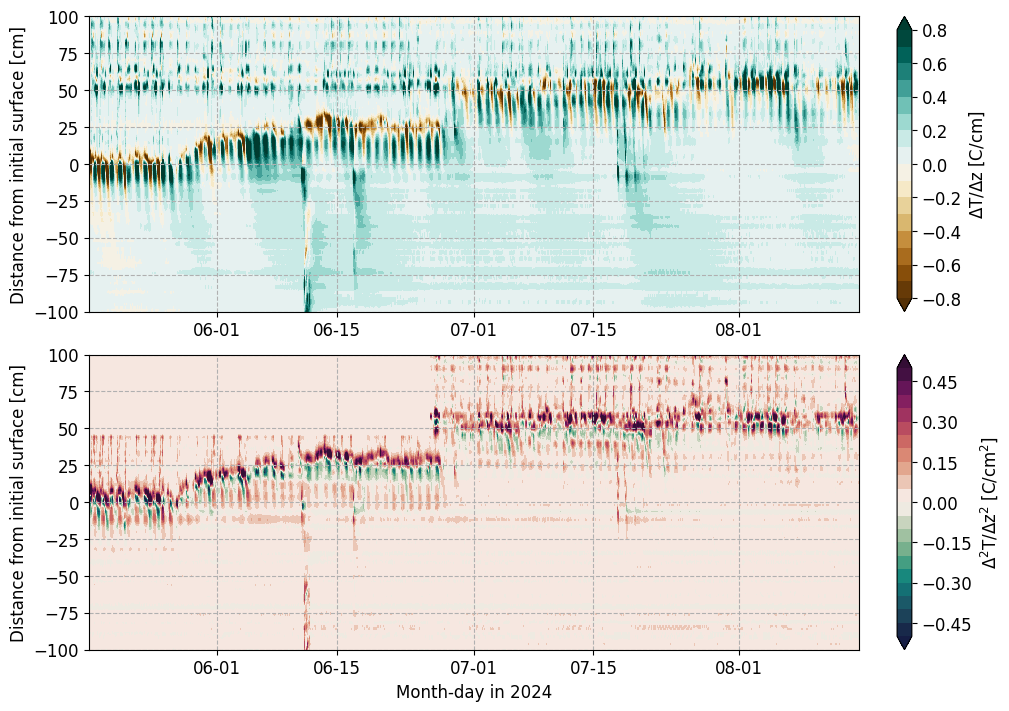

In [20]:
plt.rcParams.update({'font.size': 12})

# fig, axs = plt.subplots(3, figsize=(10,10), sharey=True, constrained_layout=True)
fig, axs = plt.subplots(2, figsize=(10,7), sharey=True, constrained_layout=True)


# cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
#                 cmap=plt.cm.plasma, levels=np.arange(-16,1.,2), extend='both')
# plt.colorbar(cb, label='Temperature [C]', ax=axs[0])

cb = axs[-2].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=plt.cm.BrBG, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='$\Delta$T/$\Delta$z [C/cm]', ax=axs[-2])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[-1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, label='$\Delta^2$T/$\Delta$z$^2$ [C/cm$^2$]', ax=axs[-1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Distance from initial surface [cm]')

axs[-1].set_xlabel('Month-day in 2024')
    
axs[0].set_ylim(-100,100)
# plt.savefig(plrams_fpath+'SIMBA_uncorrected_dTdz-d2Tdz2_sfc-detection.png', dpi=300)
plt.show()

### testing what profiles look like right after install

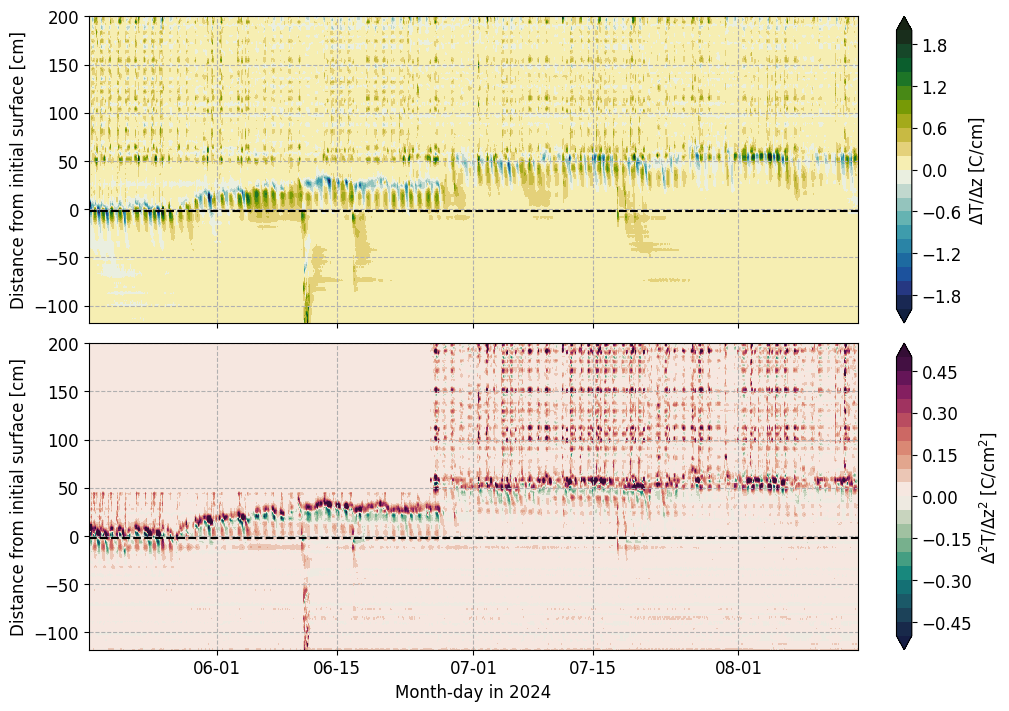

In [58]:
plt.rcParams.update({'font.size': 12})

# fig, axs = plt.subplots(3, figsize=(10,10), sharey=True, constrained_layout=True)
fig, axs = plt.subplots(2, figsize=(10,7), sharey=True, sharex=True, constrained_layout=True)


# cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
#                 cmap=plt.cm.plasma, levels=np.arange(-16,1.,2), extend='both')
# plt.colorbar(cb, label='Temperature [C]', ax=axs[0])

cb = axs[-2].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                # cmap=plt.cm.BrBG, levels=np.arange(-1.6,1.61,.2), extend='both')
                                      cmap=cmocean.cm.delta, levels=np.arange(-2.,2.1,.2), extend='both')

plt.colorbar(cb, label='$\Delta$T/$\Delta$z [C/cm]', ax=axs[-2])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[-1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, label='$\Delta^2$T/$\Delta$z$^2$ [C/cm$^2$]', ax=axs[-1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=(-180*2)+358, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Distance from initial surface [cm]')

axs[-1].set_xlabel('Month-day in 2024')
# axs[0].set_xlim(datetime(2024,5,18),datetime(2024,5,25))
# axs[0].set_ylim(-50,50)

# axs[0].set_xlim(datetime(2024,8,9),datetime(2024,8,16))
# axs[0].set_ylim(-50,50)

# plt.savefig(plrams_fpath+'SIMBA_uncorrected_dTdz-d2Tdz2_sfc-detection.png', dpi=300)
plt.show()

In [64]:
# early_idx = np.where( (simba_dates>=datetime(2024,5,18))&(simba_dates<datetime(2024,5,19)))[0]
early_idx = np.where( (simba_dates>=datetime(2024,5,18))&(simba_dates<datetime(2024,7,25)))[0]

In [72]:
# np.ma.repeat(simba_sfc[sfc_idx[0],np.newaxis], season_data_solar['temperature'].shape[1], axis=1)
depths_2d = np.ma.repeat(simba_heights[np.newaxis,:], second_vert_grad.shape[0], axis=0)
dates_2d = np.ma.repeat(simba_dates[:,np.newaxis], second_vert_grad.shape[1], axis=1)

In [104]:
masked_second_vert_grad = np.ma.masked_where(depths_2d<-10, second_vert_grad)
masked_second_vert_grad = np.ma.masked_where( (depths_2d<4)&(dates_2d>datetime(2024,5,30)), masked_second_vert_grad)
masked_second_vert_grad = np.ma.masked_where( (depths_2d<10)&(dates_2d>datetime(2024,6,7)), masked_second_vert_grad)
masked_second_vert_grad = np.ma.masked_where( (depths_2d<30)&(dates_2d>datetime(2024,6,29)), masked_second_vert_grad)
masked_second_vert_grad = np.ma.masked_where(depths_2d>65, masked_second_vert_grad)
masked_second_vert_grad = np.ma.masked_where( (depths_2d>10)&(dates_2d<datetime(2024,5,30)), masked_second_vert_grad)


In [107]:
min_dTdz_heights = []
min_dTdz_dates = []
max_dTdz_heights = []

for idx in early_idx:


    min_idx = np.ma.where(masked_second_vert_grad[idx,:]==masked_second_vert_grad[idx,:].min())[0]
    max_idx = np.ma.where(masked_second_vert_grad[idx,:]==masked_second_vert_grad[idx,:].max())[0]
    # if simba_heights[min_idx].min()>(-180*2)+358:
    #     plt.plot(second_vert_grad[idx,:], simba_heights, marker='o', zorder=1)
    #     plt.axhline(y=(-180*2)+358, c='k', ls='--')
    #     plt.scatter(second_vert_grad[idx,:][min_idx], simba_heights[min_idx], c='r', zorder=10)
    #     plt.scatter(second_vert_grad[idx,:][max_idx], simba_heights[max_idx], c='m', zorder=10)
    #     plt.ylim(-40,40)
    #     plt.grid()
    #     plt.show()
    # print(min_idx.min())
    ## surely there's a more pythonic way for this
    min_dTdz_heights.append(simba_heights[min_idx].min())
    max_dTdz_heights.append(simba_heights[max_idx].min())
    min_dTdz_dates.append(simba_dates[idx])

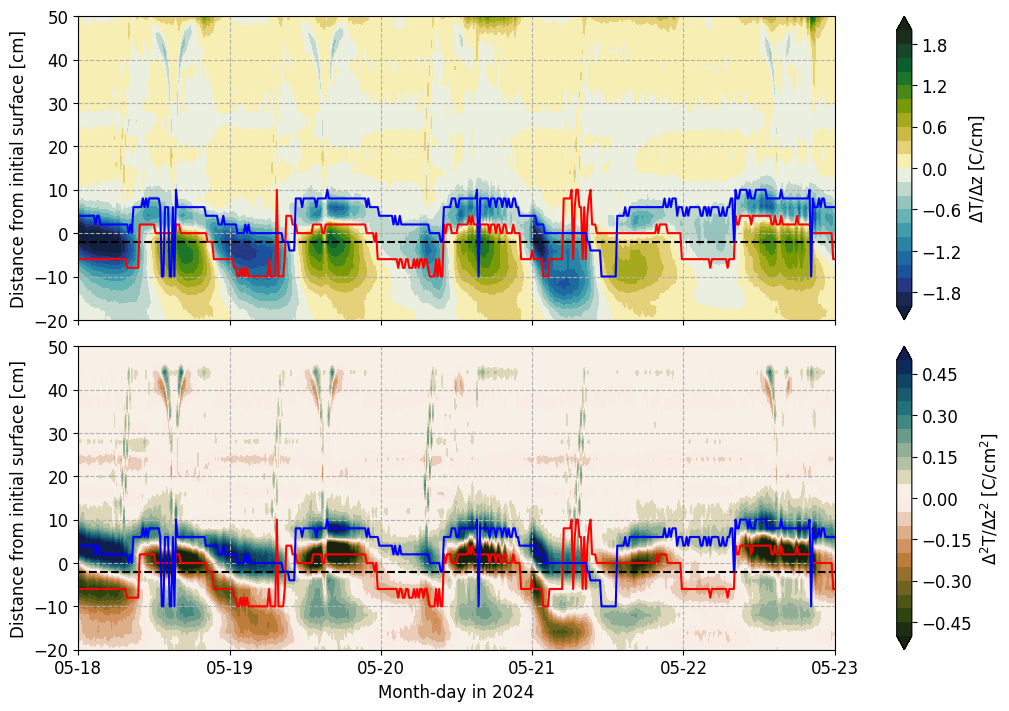

In [120]:

# fig, axs = plt.subplots(3, figsize=(10,10), sharey=True, constrained_layout=True)
fig, axs = plt.subplots(2, figsize=(10,7), sharey=True, sharex=True, constrained_layout=True)


# cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
#                 cmap=plt.cm.plasma, levels=np.arange(-16,1.,2), extend='both')
# plt.colorbar(cb, label='Temperature [C]', ax=axs[0])

cb = axs[-2].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                # cmap=plt.cm.BrBG, levels=np.arange(-1.6,1.61,.2), extend='both')
                                      cmap=cmocean.cm.delta, levels=np.arange(-2.,2.1,.2), extend='both')

plt.colorbar(cb, label='$\Delta$T/$\Delta$z [C/cm]', ax=axs[-2])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[-1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-.5,.51,.05), extend='both')
plt.colorbar(cb, label='$\Delta^2$T/$\Delta$z$^2$ [C/cm$^2$]', ax=axs[-1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

masked_min = np.ma.masked_where(min_dTdz_heights>max_dTdz_heights, min_dTdz_heights)
masked_max = np.ma.masked_where(min_dTdz_heights>max_dTdz_heights, max_dTdz_heights)

for ax in axs.ravel():
    ax.axhline(y=(-180*2)+358, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    ax.plot(min_dTdz_dates, masked_min, c='r')
    ax.plot(min_dTdz_dates, masked_max, c='b')

    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Distance from initial surface [cm]')

axs[-1].set_xlabel('Month-day in 2024')
# axs[0].set_xlim(datetime(2024,6,18),datetime(2024,6,23))
axs[0].set_xlim(datetime(2024,5,18),datetime(2024,5,23))

axs[0].set_ylim(-20,50)
# plt.savefig(plrams_fpath+'SIMBA_uncorrected_dTdz-d2Tdz2_sfc-detection.png', dpi=300)
plt.show()


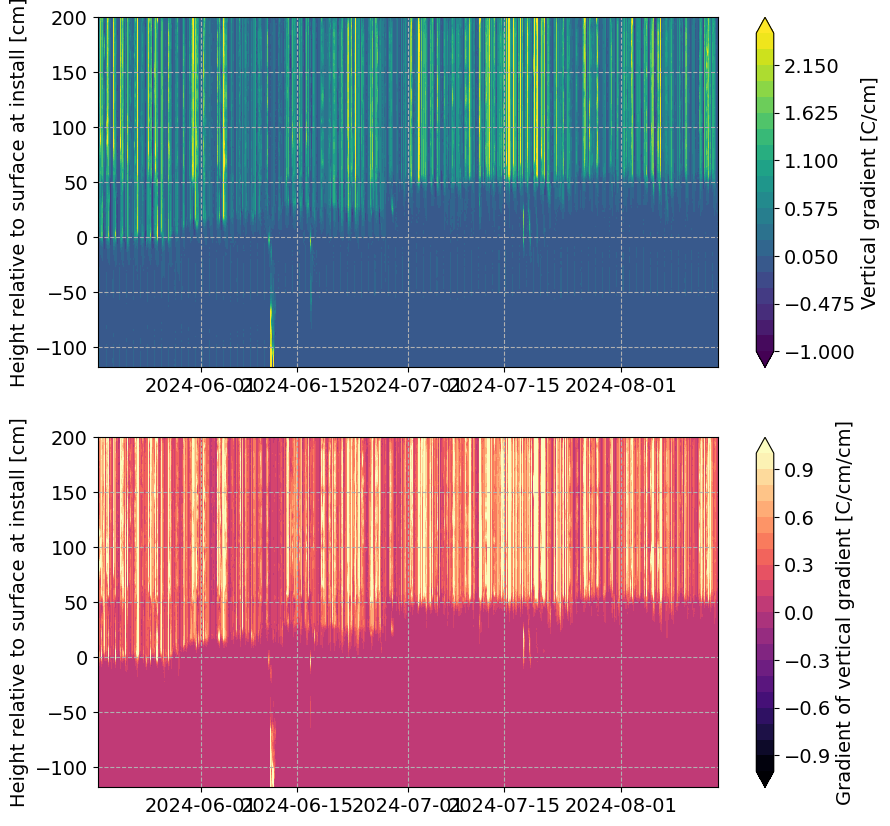

In [10]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(time_grad,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_time_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_time_grad,0,1),
                cmap='magma', levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Height relative to surface at install [cm]')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    

plt.show()

In [11]:
def get_simba_level1(start_time=datetime(2024,5,10), end_time=datetime(2024,8,23), l1_dir='/psd3data/arctic/raven/simba/level1/'):
    dates = pd.date_range(start_time, end_time)
    lev1_files = [f'{l1_dir}/firnprofile*{d.strftime("%Y%m%d")}*bottom.nc' for d in dates]

    filenames = []

    for f in lev1_files: 
        try: filenames.append(glob.glob(f)[0])
        except: 
            print(f"... couldnt open {f}")

    #print(filenames)
    try: 
        ds = xr.open_mfdataset(filenames)
    except Exception as e:
        print(f"... couldn't open, returning file list... \n {e}")
        return filenames
    return ds

In [12]:
def get_simba_level1(start_time=datetime(2024,5,10), end_time=datetime(2024,8,23), l1_dir='/psd3data/arctic/raven/simba/level1/'):
    dates = pd.date_range(start_time, end_time)
    # lev1_files = [f'{l1_dir}/firnprofile*{d.strftime("%Y%m%d")}*.nc' for d in dates]
    # lev1_files = [f'{l1_dir}/firnprofile*.nc' for d in dates]
    # lev1_files = [l1_dir+'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc']

    lev1_files = [l1_dir+'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc']

    filenames = []

    # for f in lev1_files: 
    #     try: filenames.append(glob.glob(f)[0])
    #     except: 
    #         print(f"... couldnt open {f}")

    #print(filenames)
    try: 
        # ds = xr.open_mfdataset(filenames)
        ds = xr.open_mfdataset(lev1_files)

    except Exception as e:
        print(f"... couldn't open, returning file list... \n {e}")
        return filenames
    return ds

In [13]:
def rolling_window(a, window):
    # https://stackoverflow.com/questions/27427618/how-can-i-simply-calculate-the-rolling-moving-variance-of-a-time-series-in-pytho
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [14]:
simba_dates_2d = np.repeat(simba_dates[:,np.newaxis], simba_temps.shape[1], axis=1)
simba_heights_2d = np.repeat(simba_heights[np.newaxis,:], simba_temps.shape[0], axis=0)

In [15]:
## inefficent loop because idk how to do this in two dimensions wtih pandas
masked_simba_temps = np.ma.masked_where((simba_dates_2d>=datetime(2024,7,11))&(simba_dates_2d<datetime(2024,7,12)), np.ma.copy(simba_temps) )
window = 4*12
for i in range(simba_temps.shape[0]):
# for i in range(0,3):

    try:
        time_step_var = np.ma.var(np.ma.masked_invalid(simba_temps[i:i+window+1,:]), axis=0)
    except:
        time_step_var = np.full(simba_temps.shape[0], -999)
        print(simba_dates[i])
    # print(i, time_step_var.shape)
    if i==0:
        rolling_var = time_step_var[np.newaxis,:]
    else:
        rolling_var = np.ma.concatenate((rolling_var, time_step_var[np.newaxis,:]))
print(rolling_var.shape)
    # print()

(8640, 160)


In [16]:
# rolling_var_grad = np.gradient(np.gradient(rolling_var, axis=1), axis=1)
rolling_var_grad = np.gradient(rolling_var, axis=1)


In [17]:
random_multiplied = rolling_var*vert_grad


In [18]:
print(simba_dates_2d.shape, second_vert_grad.shape, simba_heights_2d.shape)

(8640, 160) (8640, 160) (8640, 160)


In [19]:

simba_dates = season_data['dates']
second_vert_grad = np.gradient(vert_grad, axis=1)
second_vert_grad[np.where((simba_dates_2d<datetime(2024,6,26))&(simba_heights_2d>45))] = 0
# second_vert_grad[np.where(simba_heights_2d>150)] = 0

## Load data into pandas dataframe
# sds = get_simba_level1(start_time=datetime(2024,5,17), end_time=datetime(2024,8,14), l1_dir='/psd3data/arctic/sledd/Raven_simba/out_sleigh/')
sds = get_simba_level1(start_time=datetime(2024,5,17), end_time=datetime(2024,8,14), l1_dir='/psd3data/arctic/sledd/Raven_simba/')

## add second vertical temperature gradient to data frame
## why can't this be done in pandas?
sds['dT2_dH2'] = (["time", "initial_height"], second_vert_grad)
sds['dT2_dt2'] = (["time", "initial_height"], second_time_grad)
sds['rolling_time_var'] = (["time", "initial_height"], rolling_var)
sds['rolling_time_grad'] = (["time", "initial_height"], rolling_var_grad)

sds['multiplied_var'] = (["time", "initial_height"], rolling_var*second_vert_grad)
sds['multiplied_var_grad'] = (["time", "initial_height"], rolling_var_grad*second_vert_grad)

sds['random_multiplied'] = (["time", "initial_height"], random_multiplied)


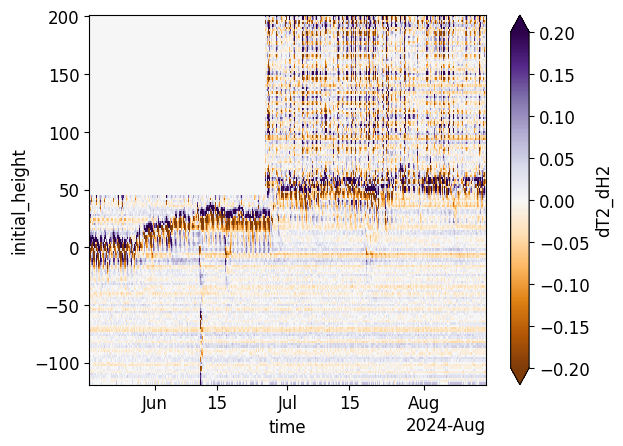

In [20]:
sds['dT2_dH2'].plot(x='time', vmin=-.2, vmax=.2, cmap='PuOr')


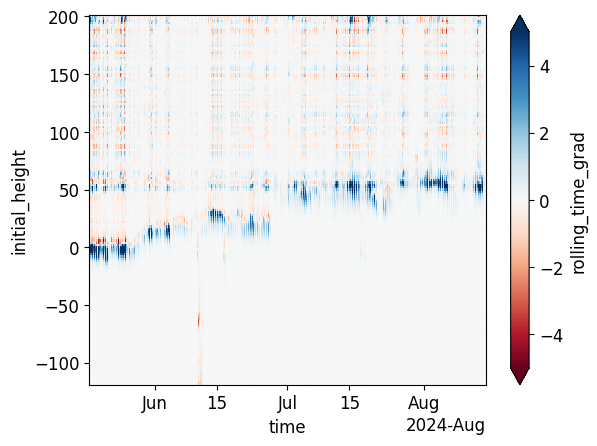

In [21]:
sds['rolling_time_grad'].plot(x='time', vmin=-5, vmax=5, cmap='RdBu')


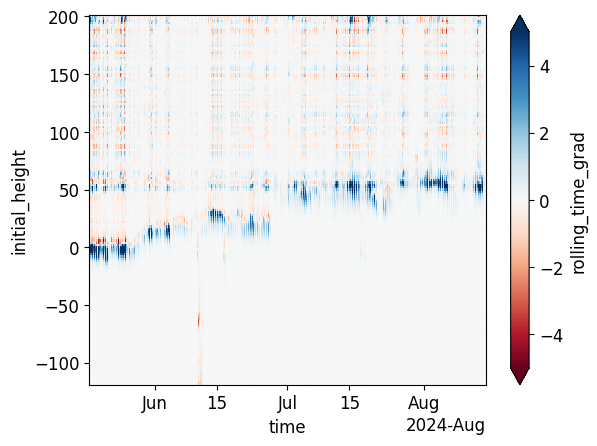

In [22]:
sds['rolling_time_grad'].plot(x='time', vmin=-5, vmax=5, cmap='RdBu')


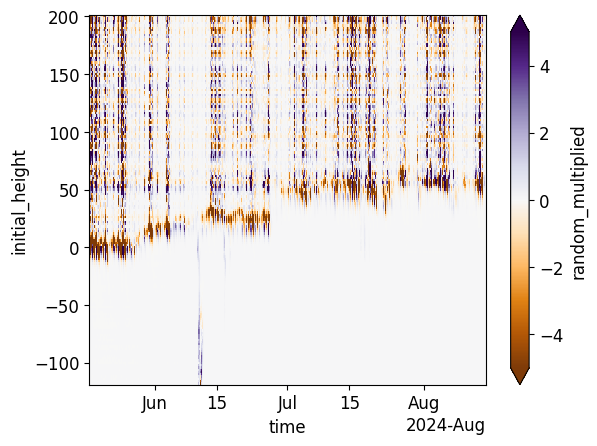

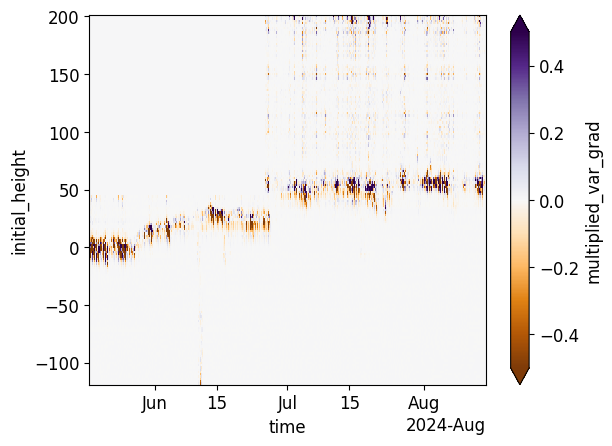

In [23]:
sds['random_multiplied'].plot(x='time', vmin=-5, vmax=5, cmap='PuOr')
plt.show()
sds['multiplied_var_grad'].plot(x='time', vmin=-.5, vmax=.5, cmap='PuOr')
plt.show()

ISSUE with using dT/dt (or rather running variance in time) is that increases in height dampen dT/dt below! Maybe not a good idea to use it then

In [24]:
# ## subset data by time (don't include after major outage)
# ## subsetting by height matters! remove noisier levels above surface and include more below
# if 'top' in lev1_files[0]:
#     ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,8,14)), initial_height=slice(75,0))]
# elif 'combined' in lev1_files[0]:
#     # ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,8,14)), initial_height=slice(-118,75))]
#     ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,7,1)), initial_height=slice(-118,50))]
# else:
#     # ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,6,27)), initial_height=slice(40,-118))]
#     ds_slice = sds.loc[dict(time=slice(datetime(2024,6,29),datetime(2024,7,26)))]

# ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,6,27)), initial_height=slice(-118,40))]
# ds_slice = sds.loc[dict(time=slice(datetime(2024,6,28),datetime(2024,7,26)), initial_height=slice(-118,100))] ## what I had been using
# ds_slice = sds.loc[dict(time=slice(datetime(2024,6,28),datetime(2024,7,26)), initial_height=slice(40,100))] ## trying to cutoff 

ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,8,14)))]

df = ds_slice['dT2_dH2'].to_pandas().transpose()
# df = ds_slice['multiplied_var_grad'].to_pandas().transpose()

df = df.mask((ds_slice['dT2_dt2'].transpose()<0.1)&(ds_slice['initial_height']<20)&(ds_slice['time']>datetime(2024,6,15)), 0.)

In [25]:
## removing columns that have nans in them (missing data in above plot)
print(df.index)
print(df.columns)
print(df)

for c in df.columns:
    if df[c].isna().sum()>0:
        df = df.drop([c], axis=1)

print(df)

Index([-118, -116, -114, -112, -110, -108, -106, -104, -102, -100,
       ...
        182,  184,  186,  188,  190,  192,  194,  196,  198,  200],
      dtype='int64', name='initial_height', length=160)
DatetimeIndex(['2024-05-17 00:00:00', '2024-05-17 00:15:00',
               '2024-05-17 00:30:00', '2024-05-17 00:45:00',
               '2024-05-17 01:00:00', '2024-05-17 01:15:00',
               '2024-05-17 01:30:00', '2024-05-17 01:45:00',
               '2024-05-17 02:00:00', '2024-05-17 02:15:00',
               ...
               '2024-08-13 21:45:00', '2024-08-13 22:00:00',
               '2024-08-13 22:15:00', '2024-08-13 22:30:00',
               '2024-08-13 22:45:00', '2024-08-13 23:00:00',
               '2024-08-13 23:15:00', '2024-08-13 23:30:00',
               '2024-08-13 23:45:00', '2024-08-14 00:00:00'],
              dtype='datetime64[ns]', name='time', length=8545, freq=None)
time            2024-05-17 00:00:00  2024-05-17 00:15:00  2024-05-17 00:30:00  \
initial_heig

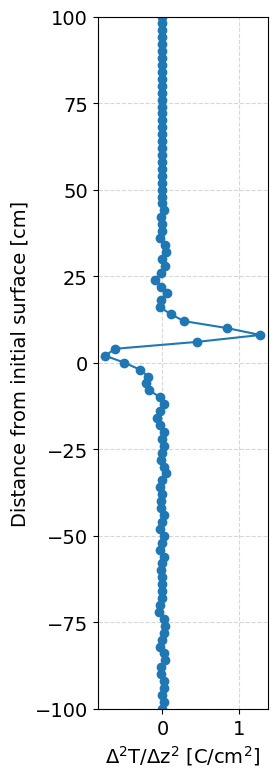

In [57]:
## Example of profile that looks like it should have an anomaly
fig, axs = plt.subplots(1,1, figsize=(3,8), sharey=True)

for c in df.columns:
    ## save for later to plot with surface ID
    example_x = df[c]
    exmample_y = df.index
    
    axs.plot(df[c],df.index, marker='o')
    axs.set_ylabel('Distance from initial surface [cm]')
    axs.set_xlabel('$\Delta^2$T/$\Delta$z$^2$ [C/cm$^2$]')
    axs.grid(alpha=.5, ls='--')
    axs.set_ylim(-100,100)
    plt.tight_layout()
    plt.savefig(plrams_fpath+'SIMBA_example_d2Tdz2-profile.png', dpi=300)

    # axs.set_xlabel('d$^2$T/dz$^2$*$/sigma_{6hr}$')
    break


In [31]:
# runnning our fancy model: removing profiles that have significant white noise based on pvalues
pvals = []

mms = preprocessing.MinMaxScaler((-1,1))
# m = mms.fit_transform(df.transpose().values)
# df_scaled[:] = mms.fit_transform(df.transpose().values).transpose()
df_filtered = df.copy()
lb_test_results = []

# p_threshold = 1.*10**-8 # combined only prior to july 1
# if 'bottom' in lev1_files[0]:
#     p_threshold = 1.*10**-5 # bottom only
# elif 'top' in lev1_files[0]:
#     p_threshold = 1.*10**-2 # bottom only
p_threshold = 1.*10**-7 ## previously -7
print("... beginning ARIMA tests for noise quantification...")
args_list = []

def run_noise_test(dff, icol):
    
    # p_threshold=0.00001# 0.00001
    if icol % 500 == 0: print(f"... still running {icol} !!")
    
    # pass me a single column of data
    try: 
        arima_res = sm.tsa.ARIMA(dff).fit()
        jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
        pval_mean = jb_res['lb_pvalue'].mean()
        if  pval_mean > p_threshold: # original threshold: 0.00001
            return True, dff.name, pval_mean
        else:
            return False, dff.name, pval_mean
    except Exception as e:
        print(f"... testing {dff.name} failed")
        return True, dff.name, np.nan

args_list = [(df_filtered[c], icol) for icol,c in enumerate(df.columns)]
    
#for icol,c in enumerate(df.columns):
    # args_list.append((df_filtered[c], ))
    
    # arima_res = sm.tsa.ARIMA(df_filtered[c]).fit()
    # jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
    # lb_test_results.append(jb_res)
    # pvals.append(jb_res['lb_pvalue'].mean())
    # if jb_res['lb_pvalue'].mean() > p_threshold: # original threshold: 0.00001
    #     df_filtered[c] = np.nan

import multiprocessing
with multiprocessing.Pool(processes=24) as pool:
    results = pool.starmap(run_noise_test, args_list)

pvals = []
for test_result, column_name, pval_mean in results:
    pvals.append(pval_mean)
    if test_result == True:
        df_filtered[column_name] = np.nan

... beginning ARIMA tests for noise quantification...
... still running 0 !!
... still running 1000 !!
... still running 2000 !!
... still running 500 !!
... still running 1500 !!
... still running 2500 !!
... still running 3500 !!
... still running 3000 !!
... still running 4000 !!
... still running 5000 !!
... still running 4500 !!
... still running 6000 !!
... still running 5500 !!
... still running 6500 !!
... still running 7500 !!
... still running 7000 !!
... still running 8500 !!
... still running 8000 !!


In [32]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

In [33]:
print(np.percentile(pvals,50))

1.1512437799238105e-11


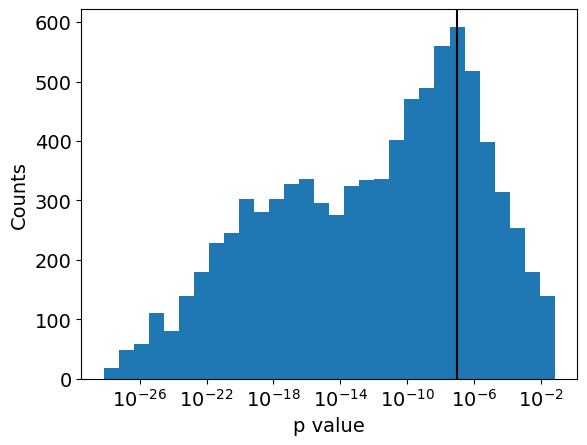

In [34]:
plot_loghist(pvals, 30)
plt.xlabel('p value')
plt.ylabel('Counts')
plt.axvline(x=p_threshold, c='k')
plt.show()

In [35]:
num_nan = df_filtered.isna().sum().sum()
num_tot = len(df_filtered)*len(df_filtered.iloc[0])
print(f" !!! threw out {np.round((num_nan/num_tot)*100,2)}% data points!!!")

 !!! threw out 24.49% data points!!!


In [36]:
# fig, axs = plt.subplots(1,1, figsize=(4,10), sharey=True)

# for c in df.columns:
#     axs.plot(df_filtered[c],df_filtered.index)

In [37]:
# ## THIS DOESN'T RUN IN ORDER!
# fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
# times = pd.DataFrame(anoms.columns)

# prev_day = anoms.columns[0].floor("D")
# for i, c in enumerate(anoms.columns):
#     curr_day = c.floor("D") 
#     if curr_day>prev_day: 
#         prev_day = curr_day
#         fig.savefig(f"plots/surface_anom_tests_filtered_{c.strftime('%Y%m%d')}.png")
#         plt.close(fig)
#         fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
#     else:
#         #axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
#         axs.plot(df_filtered[c],dfs.index, color='cadetblue', alpha=0.4)
    

In [38]:
# drop nan columns
dff = df_filtered.copy()
for c in dff.columns:
    if dff[c].isna().sum()>0:
        dff = dff.drop([c], axis=1)

HERE: trying to understand if .transpose() if doing what we want

In [39]:
t_dff = dff.copy()
print(t_dff.index)
t_dff = t_dff.transpose()
print(t_dff.index)

Index([-118, -116, -114, -112, -110, -108, -106, -104, -102, -100,
       ...
        182,  184,  186,  188,  190,  192,  194,  196,  198,  200],
      dtype='int64', name='initial_height', length=160)
DatetimeIndex(['2024-05-17 00:00:00', '2024-05-17 00:15:00',
               '2024-05-17 00:30:00', '2024-05-17 00:45:00',
               '2024-05-17 01:00:00', '2024-05-17 01:15:00',
               '2024-05-17 01:30:00', '2024-05-17 01:45:00',
               '2024-05-17 02:00:00', '2024-05-17 02:15:00',
               ...
               '2024-08-13 21:45:00', '2024-08-13 22:00:00',
               '2024-08-13 22:15:00', '2024-08-13 22:30:00',
               '2024-08-13 22:45:00', '2024-08-13 23:00:00',
               '2024-08-13 23:15:00', '2024-08-13 23:30:00',
               '2024-08-13 23:45:00', '2024-08-14 00:00:00'],
              dtype='datetime64[ns]', name='time', length=6451, freq=None)


In [40]:
# do the normalization/scaling in the horizontal for bumping signal to noise ratio
# rsdf = dff.copy()
# mms = preprocessing.RobustScaler(quantile_range=(0.4,0.6),with_centering=True)
# m = mms.fit_transform(rsdf.transpose()) # original with transpose()
# dfs = pd.DataFrame(m.transpose(), columns=dff.columns,index=dff.index) # original with transpose


In [41]:
# this is scaling in the vertical but seems worse than horizontal
rsdf = dff.copy()
mms = preprocessing.RobustScaler(quantile_range=(0.1,0.9),with_centering=True)
m = mms.fit_transform(rsdf) # original with transpose()
dfs = pd.DataFrame(m, columns=rsdf.columns,index=rsdf.index)

In [42]:
# fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)

# for c in dfs.columns:
#     axs.plot(dfs[c],dfs.index)



Idea from michael: daily average sample???

In [43]:
# model = LocalOutlierFactor(n_neighbors=20, contamination=0.35) # 20
model = LocalOutlierFactor(n_neighbors=20, contamination=0.10) # best so far?
# model = LocalOutlierFactor(n_neighbors=15, contamination=0.35)


model.fit(dfs)
y_pred = model.fit_predict(dfs)
anoms = dfs[y_pred==-1]

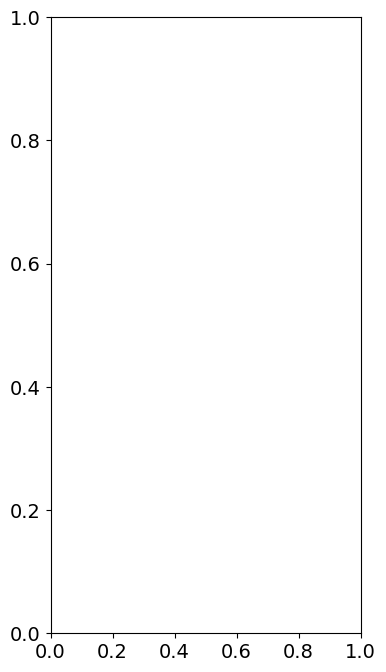

In [44]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
for i, c in enumerate(anoms.columns):
    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
    else:
        axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
        axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.4, marker='o')
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)

    

In [45]:
# the algorithm drops anything it doesn't identify as anomalous in height, recreate with np.nan in those places
fixed_anoms = df.copy()
fixed_anoms[:] = np.nan
aa = anoms.copy()
for c in anoms.columns:
    fixed_anoms.loc[anoms[c].index, c] = anoms[c]


In [46]:
aa = pd.DataFrame(columns=fixed_anoms.columns, index=['max_val','max_index'])

for c in fixed_anoms:
    max_i = fixed_anoms[c].abs().idxmax()
    max_v   = fixed_anoms[c].abs().max()
    aa.loc['max_val',c] = max_v
    aa.loc['max_index',c] = max_i

In [47]:
aa

time,2024-05-17 00:00:00,2024-05-17 00:15:00,2024-05-17 00:30:00,2024-05-17 00:45:00,2024-05-17 01:00:00,2024-05-17 01:15:00,2024-05-17 01:30:00,2024-05-17 01:45:00,2024-05-17 02:00:00,2024-05-17 02:15:00,...,2024-08-13 21:45:00,2024-08-13 22:00:00,2024-08-13 22:15:00,2024-08-13 22:30:00,2024-08-13 22:45:00,2024-08-13 23:00:00,2024-08-13 23:15:00,2024-08-13 23:30:00,2024-08-13 23:45:00,2024-08-14 00:00:00
max_val,4.716981,4.991192,4.805335,5.057874,5.217553,5.060918,5.021387,5.134166,4.65718,4.789182,...,6.15239,10.107015,10.411737,0.203125,7.572172,15.457788,15.081206,7.075472,7.530717,7.058824
max_index,2,2,2,2,2,2,2,2,2,2,...,58,58,58,48,48,48,48,54,54,54


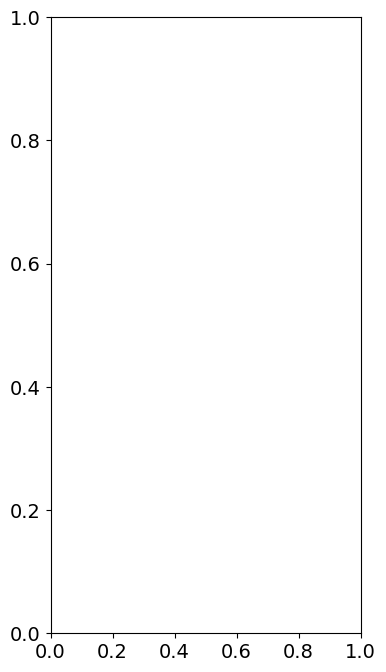

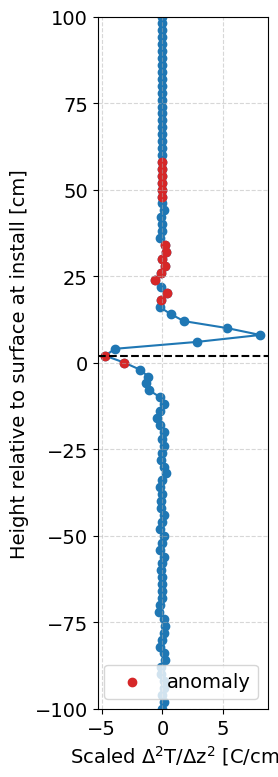

In [60]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
day_success = False

for i, c in enumerate(anoms.columns):

    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}_pAMS.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
        
        if day_success: print(f"... successfull/y calculated surface height for timestep {c}")
        day_success = False
        
    else:
        # axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.2)
        # axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.2)
        fig, axs = plt.subplots(1,1, figsize=(3,8), sharey=True)
        axs.plot(dfs[c],dfs.index, color='tab:blue', marker='o',zorder=0)
        axs.scatter(anoms[c],anoms.index, color='tab:red',zorder=1, label='anomaly')
        
        try: 
            axs.axhline(y=aa.loc['max_index',c], color="black", linestyle="--",)#alpha=0.01)
            if day_success==False: 
                day_success = True
        except: 
            do_nothing = True
        # 
        axs.set_ylabel('Height relative to surface at install [cm]')
        axs.set_xlabel('Scaled $\Delta^2$T/$\Delta$z$^2$ [C/cm$^2$]')
        axs.grid(alpha=.5, ls='--')
        axs.set_ylim(-100,100)
        axs.legend(loc='lower right')
        plt.tight_layout()
        break
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)
plt.savefig(plrams_fpath+'SIMBA_sfc-detection_scaled-d2Tdz2_anoms_sfc.png', dpi=300)


In [304]:
def despike_rolling(df_column, window=10, threshold=3):
    rolling_median = df_column.rolling(window=window, center=True, min_periods=1).median()
    rolling_std = df_column.rolling(window=window, center=True, min_periods=1).std()
    df_clean = df_column[np.abs(df_column - rolling_median) <= (threshold * rolling_std)]
    return df_clean

In [305]:
print(aa)

time      2024-05-17 00:00:00 2024-05-17 00:15:00 2024-05-17 00:30:00  \
max_val              4.716981            4.991192            4.805335   
max_index                   2                   2                   2   

time      2024-05-17 00:45:00 2024-05-17 01:00:00 2024-05-17 01:15:00  \
max_val              5.057874            5.217553            5.060918   
max_index                   2                   2                   2   

time      2024-05-17 01:30:00 2024-05-17 01:45:00 2024-05-17 02:00:00  \
max_val              5.021387            5.134166             4.65718   
max_index                   2                   2                   2   

time      2024-05-17 02:15:00  ... 2024-08-13 21:45:00 2024-08-13 22:00:00  \
max_val              4.789182  ...             6.15239           10.107015   
max_index                   2  ...                  58                  58   

time      2024-08-13 22:15:00 2024-08-13 22:30:00 2024-08-13 22:45:00  \
max_val             10.411737   

In [306]:
## make time the index so that you can use groupby to get daily/hourly/whatever statistics
aa_formated = aa.copy().transpose()

In [307]:
aa_formated['max_index'] = aa_formated['max_index'].clip(lower=0)


In [308]:
print(aa_formated)

                       max_val max_index
time                                    
2024-05-17 00:00:00   4.716981         2
2024-05-17 00:15:00   4.991192         2
2024-05-17 00:30:00   4.805335         2
2024-05-17 00:45:00   5.057874         2
2024-05-17 01:00:00   5.217553         2
...                        ...       ...
2024-08-13 23:00:00  15.457788        48
2024-08-13 23:15:00  15.081206        48
2024-08-13 23:30:00   7.075472        54
2024-08-13 23:45:00   7.530717        54
2024-08-14 00:00:00   7.058824        54

[8543 rows x 2 columns]


<Axes: xlabel='time'>

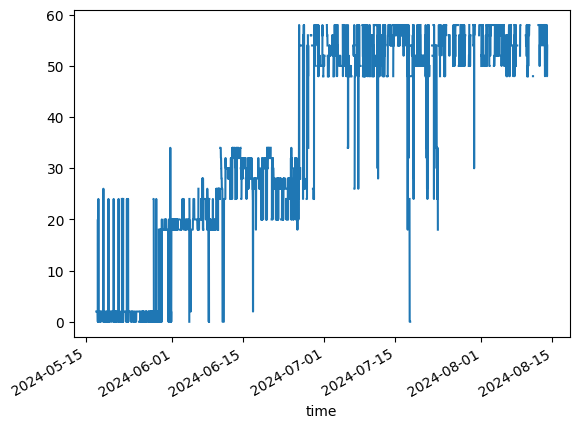

In [309]:
aa_formated['max_index'].plot()

In [310]:
def rolling_min(df_column, window=10, threshold=3):
    rolling_min = df_column.rolling(window=window, center=True, min_periods=1).min()
    # rolling_std = df_column.rolling(window=window, center=True, min_periods=1).std()
    # df_clean = df_column[np.abs(df_column - rolling_median) <= (threshold * rolling_std)]
    return rolling_min

In [311]:
aa_6h = aa_formated.groupby(pd.Grouper(freq='6H'))

## .quantiles not playing nice with .groupy()?
aa_min_6h = []

for group in aa_6h:
    g = group[1]['max_index']#.values
    # print(g.quantile(0.25), g.quantile(0.75))

    # print(g['max_index'].between(-350,-340))
    middle_g = g[g.between(g.quantile(0.25), g.quantile(0.75))]
    # print(middle_g.min())
    # group_middle = g.between(g.transform('quantile', 0.25), g.transform('quantile', 0.75))
    aa_min_6h.append(middle_g.min())

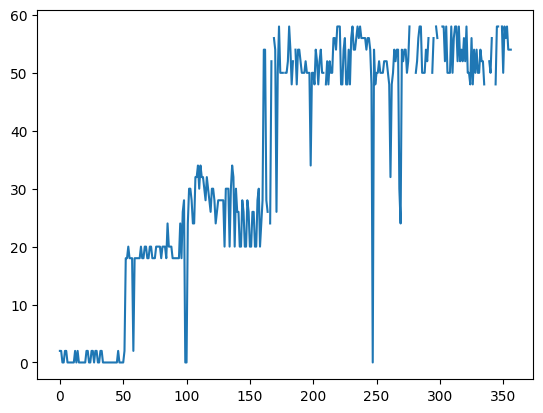

In [312]:
plt.plot(aa_min_6h)



In [313]:
aa_mode = aa_formated.groupby(pd.Grouper(freq='12H'))#.mode()
aa_min = aa_formated.groupby(pd.Grouper(freq='4H')).min()
aa_med = aa_formated.groupby(pd.Grouper(freq='4H')).median()


## groupby doesn't have option for mode???

days = []
modal_height = []

for item in aa_mode:
    days.append(item[1].index[0].date() )
    # print(item[1].index[0])
    # print(item[1]['max_index'].mode().values.min())
    try: 
        modal_height.append(item[1]['max_index'].mode().values.min())
    except:
        modal_height.append(np.nan)
    # print(item[1]['max_index'].mode().values)
# print(aa_mode)
modal_height = np.asarray(modal_height)
days = np.asarray(days)

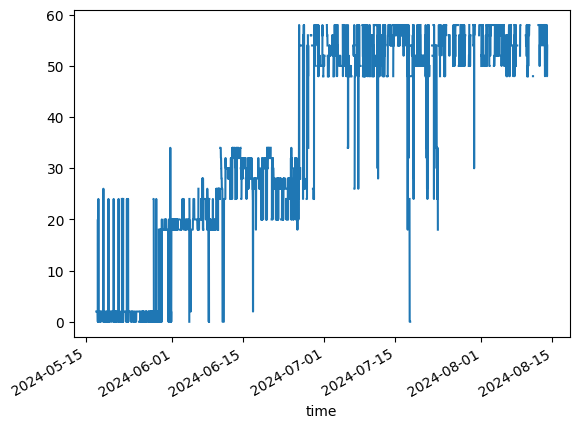

In [314]:
aa_formated['max_index'].plot()
# plt.xlim(datetime(2024,6,8), datetime(2024,6,15))

plt.show()

In [315]:
despike_aa = despike_rolling(aa_min['max_index'],window=4*6, threshold=.6) #window=4*18, threshold=1)
despike_raw = despike_rolling(aa.loc['max_index',:], window=4*24, threshold=.6)
# despike_mode = despike_rolling(modal_height, window=4*18, threshold=1)

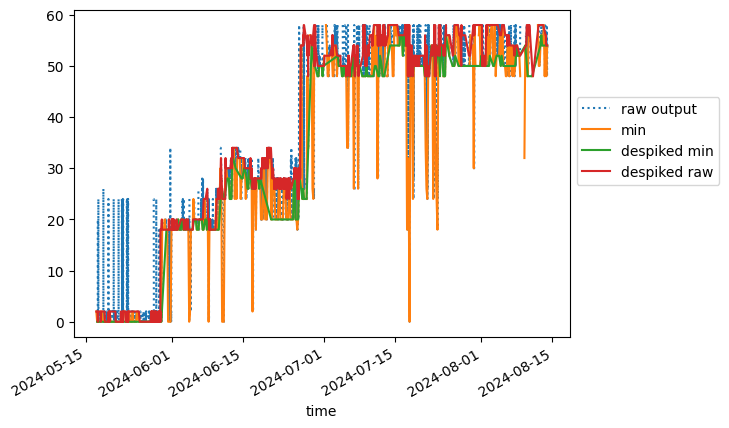

In [316]:
aa.loc['max_index',:].plot(ls=':', label='raw output')
aa_min.loc[:,'max_index'].plot(label='min')# plt.plot(days, modal_height, label='12h mode')
despike_aa.plot(label='despiked min')
despike_raw.plot(label='despiked raw')
plt.legend(loc='center left', bbox_to_anchor=(1,.6))


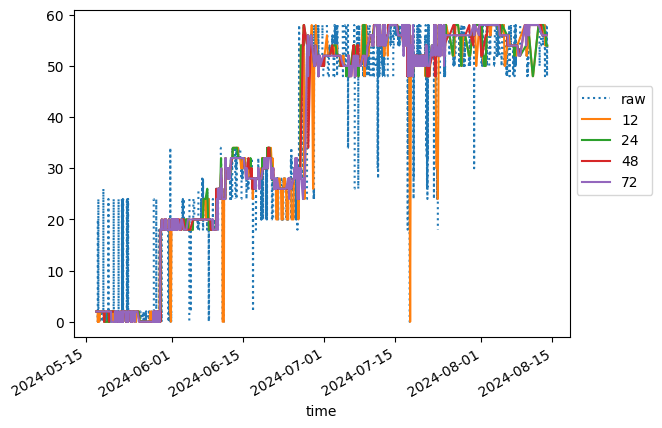

In [319]:
aa_formated['max_index'].plot(label='raw', ls=':')
# for t in [1,.8,.6,.5]:
for t in [12,24,48,72]:

    # despike_t = despike_rolling(aa.loc['max_index',:],window=4*48, threshold=t) #window=4*18, threshold=1)
    despike_t = despike_rolling(aa_formated['max_index'],window=4*t, threshold=.5)

    despike_t.plot(label=t)
plt.legend(loc='center left', bbox_to_anchor=(1,.6))
# plt.xlim(datetime(2024,6,8), datetime(2024,6,15))
plt.show()

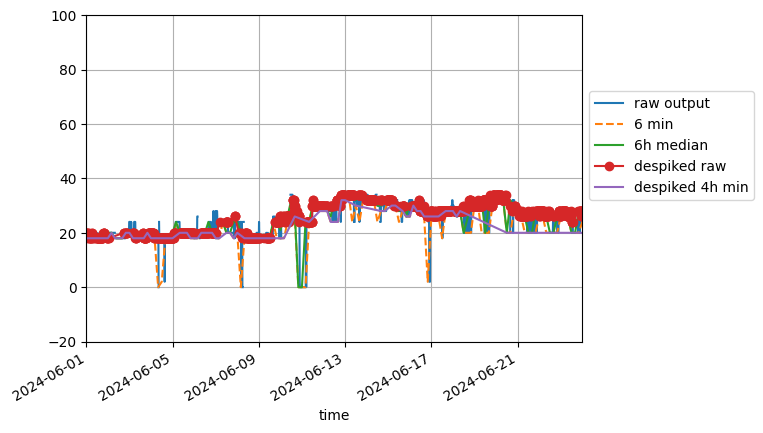

In [320]:
aa_formated['max_index'].plot(label='raw output')
# aa.loc['max_index',:].plot(label='raw output')

aa_min['max_index'].plot(label='6 min', ls='--')
aa_med['max_index'].plot(label='6h median')

despike_raw.plot(label='despiked raw', marker='o')
despike_aa.plot(label='despiked 4h min')
# despike_raw.plot(label='despiked raw')
# plt.plot(days, modal_height, label='modal')
plt.legend(loc='center left', bbox_to_anchor=(1,.6))
plt.xlim(datetime(2024,6,1), datetime(2024,6,24))
plt.ylim(-20,100)
plt.grid()
plt.show()


In [326]:
despike_raw = despike_rolling(aa.loc['max_index',:],window=4*72, threshold=.5) #window=4*18, threshold=1)
despike_aa = despike_rolling(aa_min['max_index'],window=4*72, threshold=.5) #window=4*18, threshold=1)


In [327]:
rolling_despiked_raw = despike_raw.rolling(window=4*24*2, center=True, min_periods=1).mean()

In [328]:
def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [329]:
rolling_despiked_raw_even = rolling_despiked_raw.apply(lambda x:np.floor(x)+np.floor(x)%2)

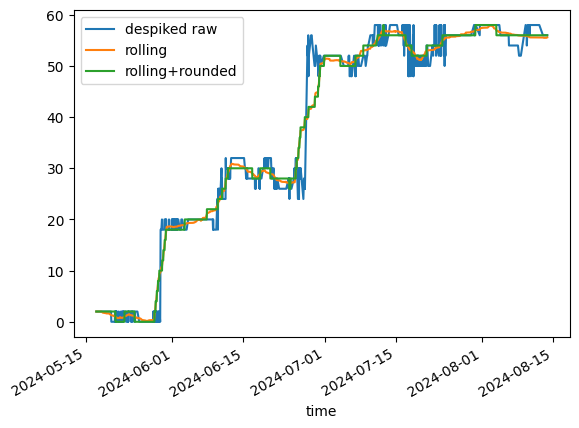

In [330]:
despike_raw.plot(label='despiked raw')
rolling_despiked_raw.plot(label='rolling')
rolling_despiked_raw_even.plot(label='rolling+rounded')
plt.legend(loc='best')
plt.show()

In [331]:
## save to csv for comparison with other data/notebook
# despike_raw.to_csv('Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_bottom_20240517-20240627.csv')
# rolling_despiked_raw_even.to_csv('Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_combined-corrected_rolling_20240629-20240726.csv')
# rolling_despiked_raw_even.to_csv('Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_combined-corrected_rolling_20240517-20240627.csv')

# despike_aa.to_csv('Raven2024_SIMBA_sfc_id_v2_4hmin-despiked-6h-06threshold_d2Tdz2_combined-corrected_20240517-20240627.csv')
# despike_aa.to_csv('Raven2024_SIMBA_sfc_id_v2_4hmin-despiked-6h-06threshold_d2Tdz2_combined-corrected_20240628-20240726.csv')

# despike_aa.to_csv('Raven2024_SIMBA_sfc_id_v2_4hmin-despiked-6h-06threshold_combined-corrected_20240628-20240726.csv')

despike_raw.to_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')
# rolling_despiked_raw_even.to_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-48h-1threshold_rolling-mean_20250415.csv')

# despike_raw.to_csv('Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_bottom_20240517-20240627.csv')
# despike_raw.to_csv('Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_bottom_20240629-20240726.csv')

#     ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,6,27)), initial_height=slice(40,-118))]


### Checking surface as compared to old surface ID

In [332]:
import math

def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [333]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

## broke convolve when updating cmocean; np.convolve has weird edge effects
# simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
N = 4*6+1
simba_sfc = np.convolve(simba_sfc_heights, np.ones(N)/N, mode='same')

simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc]) ## can also do round_down_to_even()
# simba_sfc = np.ma.masked_where(season_data['dates']<datetime(2024,5,15,3), simba_sfc) # masked weird edges
# simba_sfc = np.ma.masked_where(season_data['dates']>=datetime(2024,8,22,21), simba_sfc)

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
# simba_sfc = np.ma.masked_where((season_data['dates']>=datetime(2024,6, 25))&(season_data['dates']<datetime(2024,6, 26)), simba_sfc)


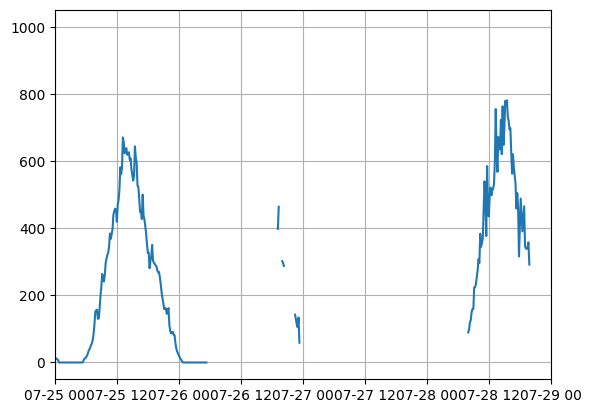

In [334]:
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp'])
plt.xlim(datetime(2024,7,25), datetime(2024,7,29))
plt.grid()
plt.show()

In [185]:

surface_ids = {}
sections = ['20240517-20240627','20240628-20240726']
# sections = ['20240517-20240627','20240629-20240726']
for section in sections:
    surface_ids[section] = {}

    fname = 'Raven2024_SIMBA_sfc_id_v2_4hmin-despiked-6h-06threshold_d2Tdz2_combined-corrected_'+section+'.csv'


    df = pd.read_csv('/home/asledd/ICECAPS/'+fname) 
    surface_ids[section]['dates'] = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])

    surface_ids[section]['surface'] = df['max_index'].values

simba_sfc_dates = np.concatenate((surface_ids[sections[0]]['dates'], surface_ids[sections[1]]['dates']))
simba_sfc_in = np.concatenate((surface_ids[sections[0]]['surface'], surface_ids[sections[1]]['surface']))

NameError: name 'despike_raw' is not defined

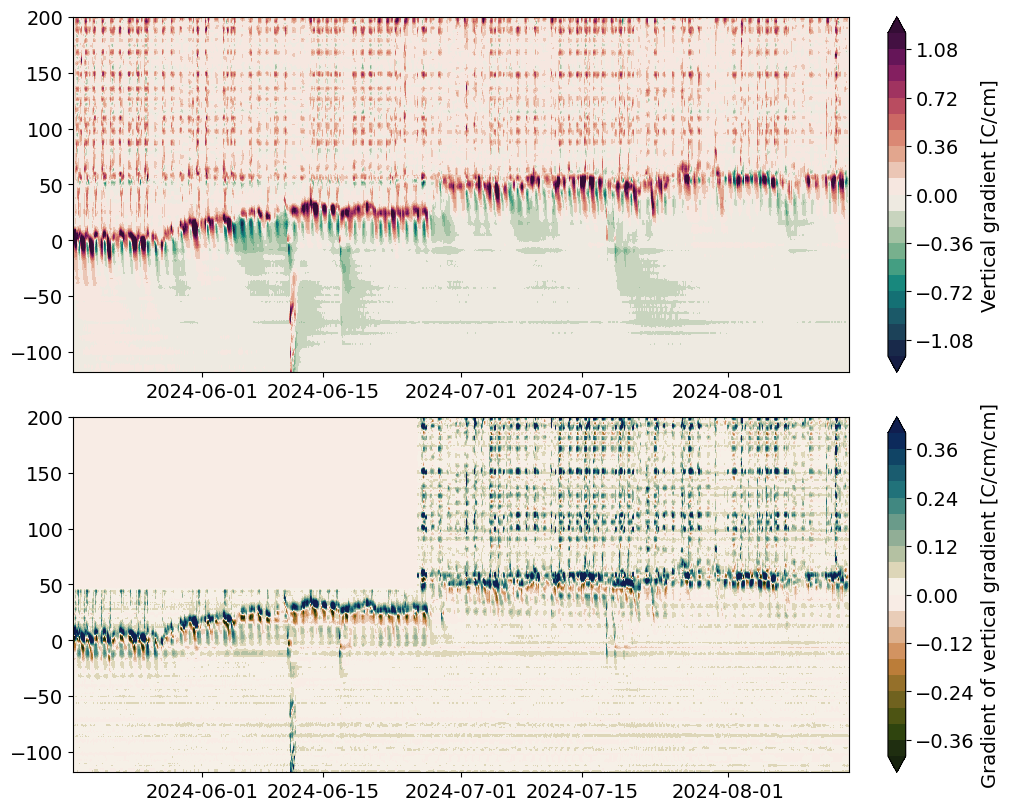

In [61]:

fig, axs = plt.subplots(2, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(-vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-.4,.4,21), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


# axs[0].set_ylim(-40, 40) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax, c in zip(axs.ravel(),['k','k']):
    ax.plot(despike_raw.index,despike_raw.values , c='k', label='surface detection: despiked raw')
    ax.plot(rolling_despiked_raw_even.index,rolling_despiked_raw_even.values , c='b', label='rolling mean')

    # ax.plot(simba_sfc_dates, simba_sfc_in, c=c, label='SIMBA surface')
    # ax.plot(days,modal_height, c='limegreen', label='24h mode')
    
    # ax.plot(season_data['dates'], simba_sfc, c='k', label='old method', lw=1)
    # ax.plot(season_data['dates'], simba_sfc-6., c='gray', ls='--')

    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_ylim(-50,100)
    # ax.set_xlim(datetime(2024,5,17), datetime(2024,7,26))
    # ax.set_xlim(datetime(2024,7,1), datetime(2024,7,26))

    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='c')
    ax.plot(asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser', c='m')

axs[0].legend(loc='lower right')
plt.show()

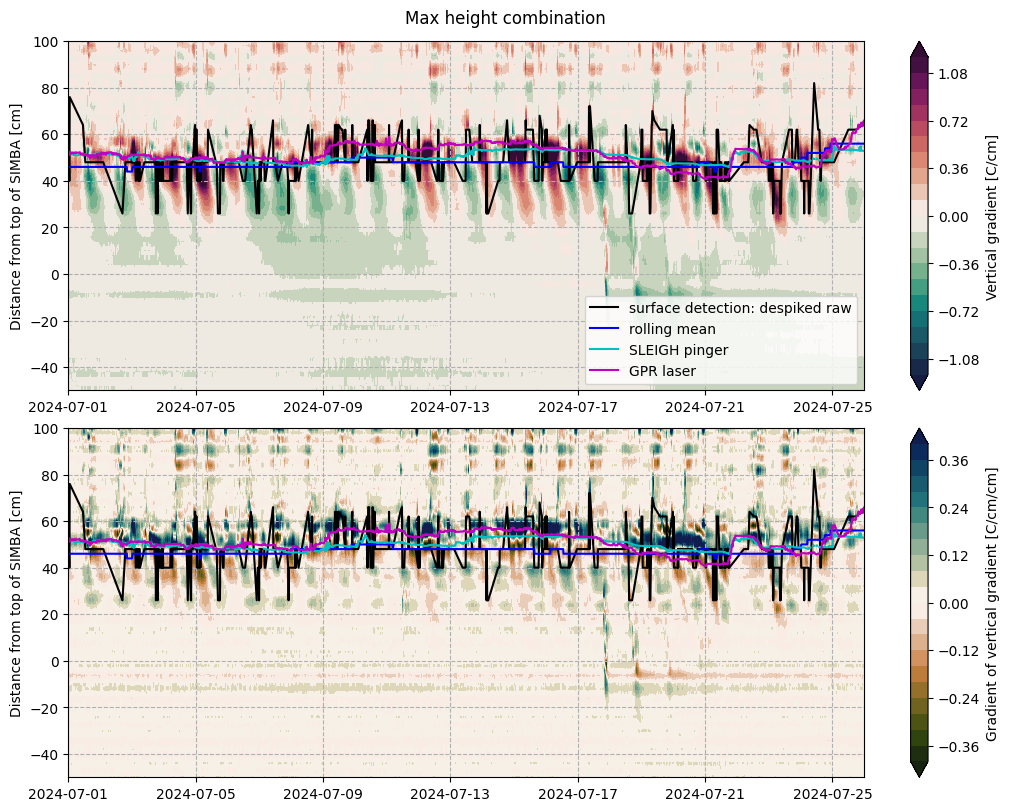

In [184]:

fig, axs = plt.subplots(2, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(-vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-.4,.4,21), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])

fig.suptitle('Max height combination')
# axs[0].set_ylim(-40, 40) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax, c in zip(axs.ravel(),['k','k']):
    ax.plot(despike_raw.index,despike_raw.values , c='k', label='surface detection: despiked raw')
    ax.plot(rolling_despiked_raw_even.index,rolling_despiked_raw_even.values , c='b', label='rolling mean')

    # ax.plot(simba_sfc_dates, simba_sfc_in, c=c, label='SIMBA surface')
    # ax.plot(days,modal_height, c='limegreen', label='24h mode')
    
    # ax.plot(season_data['dates'], simba_sfc, c='k', label='old method', lw=1)
    # ax.plot(season_data['dates'], simba_sfc-6., c='gray', ls='--')

    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_ylim(-50,100)
    # ax.set_xlim(datetime(2024,5,17), datetime(2024,7,26))
    ax.set_xlim(datetime(2024,7,1), datetime(2024,7,26))

    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='c')
    ax.plot(asfs_data_lev2['dates'], (asfs_data_lev2['snow_gpr_dist'][0]-asfs_data_lev2['snow_gpr_dist'])*100., label='GPR laser', c='m')

axs[0].legend(loc='lower right')
plt.show()

In [ ]:

fig, axs = plt.subplots(2, figsize=(8,6), sharey=True, sharex=True, constrained_layout=True)


cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='dT/dz [C/cm]', ax=axs[1])

cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
                cmap=cmocean.cm.thermal, levels=np.linspace(-20,0,21), extend='both')
plt.colorbar(cb, label='Temperature [C]', ax=axs[0])


# axs[0].set_ylim(-40, 40) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax, c in zip(axs.ravel(),['k','k']):
    # ax.plot(despike_raw.index,despike_raw.values , c='limegreen', label='surface detection: despiked raw')
    # ax.plot(despike_aa.index,despike_aa.values , c=c, label='surface detection: despiked 4hr min')

    ax.plot(simba_sfc_dates, simba_sfc_in, c=c, label='SIMBA surface')
    # ax.plot(days,modal_height, c='limegreen', label='24h mode')
    
    # ax.plot(season_data['dates'], simba_sfc, c='k', label='old method', lw=1)
    # ax.plot(season_data['dates'], simba_sfc-6., c='gray', ls='--')

    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Height relative to initial surface [cm]')
    ax.set_ylim(-50,100)
    ax.set_xlim(datetime(2024,5,17), datetime(2024,7,26))
    # ax.set_xlim(datetime(2024,6,22), datetime(2024,7,1))

    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='c')

axs[0].legend(loc='lower right')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].set_xlabel('Month-day in 2024')
plt.show()

### Check how the different sections align with pinger

In [182]:
from datetime import timedelta

In [183]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['down_short_hemisp','snow_depth_qc','snow_depth','snow_gpr_dist','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )


/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

surface_ids = {}



for section in ['top','bottom']:
    surface_ids[section] = {}
    # if section=='bottom':
    #     # fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_20250325_fixedagain_bottom.csv'
    if section=='bottom':
        fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_0.001pval_20250325_v10_bottom.csv'
    else:
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_fixedagain_'+section+'.csv'
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_0.001pval_20250325_v10_'+section+'.csv'
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_fixedagainmore_'+section+'.csv'
        fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_0.005pval_20250325_v10_top.csv'
    # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_'+section+'.csv'

    df = pd.read_csv('/home/asledd/ICECAPS/'+fname) 
    surface_ids[section]['dates'] = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
    surface_ids[section]['surface'] = df['max_index'].values


fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH', c='k')
for section in surface_ids:
    if section=='top':
        plt.plot(surface_ids[section]['dates'], 
                 np.ma.masked_where(surface_ids[section]['dates']<datetime(2024,6,1), surface_ids[section]['surface']),
                 label=section)
    elif section=='bottom':
        plt.plot(surface_ids[section]['dates'], 
                 np.ma.masked_where(surface_ids[section]['dates']>datetime(2024,6,15), surface_ids[section]['surface']),
                 label=section)        
plt.ylabel('Height [cm]')
plt.legend(loc='best')
plt.grid(ls='--', alpha=.5)
plt.show()

In [260]:
surface_ids = {}

for section in ['20240517-20240627','20240629-20240726']:
    surface_ids[section] = {}

    fname = 'Raven2024_SIMBA_sfc_id_v2_raw-despiked-48h-06threshold_20250328_bottom_'+section+'.csv'

    df = pd.read_csv('/home/asledd/ICECAPS/'+fname) 
    surface_ids[section]['dates'] = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
    surface_ids[section]['surface'] = df['max_index'].values

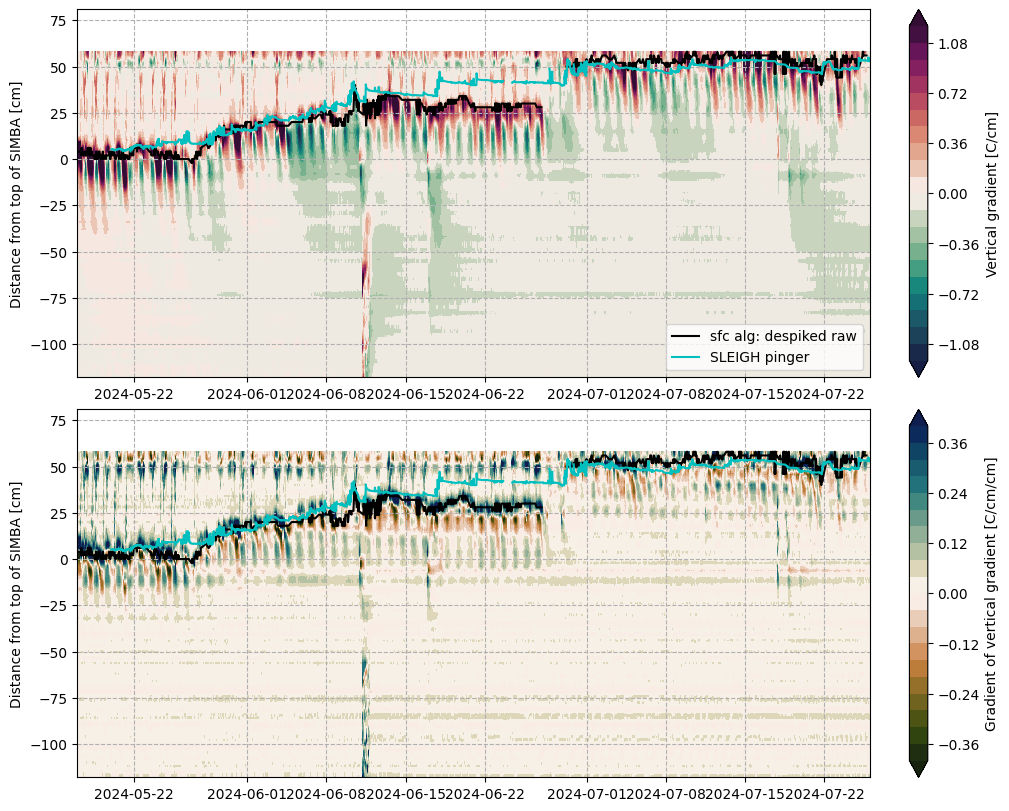

In [457]:

fig, axs = plt.subplots(2, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-.4,.4,21), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])

for ax in axs.ravel():

    for section, label in zip(surface_ids,['sfc alg: despiked raw','']):
    
        ax.plot(surface_ids[section]['dates'], surface_ids[section]['surface'], label=label, c='k')     
    
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    # ax.set_ylim(-50,100)
    ax.set_xlim(datetime(2024,5,17), datetime(2024,7,26))
    # ax.set_xlim(datetime(2024,6,22), datetime(2024,7,1))

    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='c')

axs[0].legend(loc='lower right')
plt.show()